In [10]:
"""
Dataset Description:
 - Format: Collection of CSV files organized by Singapore regions (e.g., D01.., D02..)
 - Content: Housing transaction prices and property details
 - Source: https://eservice.ura.gov.sg/property-market-information/pmiResidentialTransactionSearch
 - GitHub Repo: https://github.com/luka07077/housing_price_prediction_model

And the following is the path definition of dataset
"""


import pandas as pd
import os

# Path definition
# Please modify the path when you switch the runtime env
current_folder = "/Users/luka/Desktop/CA6000/CA6000_Dataset"
desktop_path = "/Users/luka/Desktop/CA6000/"
output_csv_path = os.path.join(desktop_path, "Final_Cleaned_Data_Fixed.csv")

# process by the name order
all_data_list = []
all_files = os.listdir(current_folder)
all_files.sort()

In [2]:
# Check the specific data column
# Note: Pay attention to the file encoding format

print("=== Starting Check for Non-Strata Types ===")
found_issues = False

for file_name in all_files:
    if file_name.endswith(".csv") and "Final" not in file_name:
        full_path = os.path.join(current_folder, file_name)
        
        try:
            # Read using ISO-8859-1 as before, fast and high tolerance
            df = pd.read_csv(full_path, encoding='ISO-8859-1')
        except Exception as e:
            print(f"[Error] Unable to read {file_name}: {e}")
            continue

        # Standardize column name format
        df.columns = df.columns.str.lower().str.strip()
        
        target_col = 'type of area'
        
        if target_col in df.columns:
            # 1. Convert column to string, lower case, and strip whitespace
            # 2. Filter for unique values that are not 'strata'
            # Note: dropna() ignores nulls. If you want to count nulls as anomalies, adjust logic
            unique_values = df[target_col].astype(str).str.lower().str.strip().unique()
            
            # Find values that are not 'strata'
            non_strata = [val for val in unique_values if val != 'strata']
            
            if len(non_strata) > 0:
                found_issues = True
                print(f"Found different type -> File: {file_name}")
                print(f"    Contains: {non_strata}\n")
        else:
            print(f"[Warning] File {file_name} missing '{target_col}' column")

if not found_issues:
    print("Check complete: All Type of Area values in files are 'Strata' (or empty).")
else:
    print("Check complete.")

=== Starting Check for Non-Strata Types ===
Found different type -> File: D08 : Little India.csv
    Contains: ['land']

Found different type -> File: D09 : Orchard, Cairnhill, River Valley.csv
    Contains: ['land']

Found different type -> File: D10 : Ardmore, Bukit Timah, Holland Road, Tanglin.csv
    Contains: ['land']

Found different type -> File: D11 : Watten Estate, Novena, Thomson.csv
    Contains: ['land']

Found different type -> File: D12 : Balestier, Toa Payoh, Serangoon.csv
    Contains: ['land']

Found different type -> File: D14 : Geylang, Eunos.csv
    Contains: ['land']

Found different type -> File: D15 : Katong, Joo Chiat, Amber Road.csv
    Contains: ['land']

Found different type -> File: D20 : Bishan, Ang Mo Kio.csv
    Contains: ['land']

Found different type -> File: D28 : Seletar.csv
    Contains: ['land']

Check complete.


In [3]:
# Data Cleaning and Processing
# Note: Pay attention to the file encoding format

print("=== Starting Processing Task ===")

for file_name in all_files:
    if file_name.endswith(".csv") and "Final" not in file_name:
        
        full_path = os.path.join(current_folder, file_name)
        
        # Handle file reading
        try:
            df = pd.read_csv(full_path, encoding='ISO-8859-1')
        except:
            print(f"[Skipped] Unable to read file: {file_name}")
            continue

        original_rows = len(df)
        print(f"\nProcessing file: {file_name}")

        # Step 1: Standardize column names
        df.columns = df.columns.str.lower().str.strip()

        # Drop 'nett price($)' column
        if 'nett price($)' in df.columns:
            df.drop(columns=['nett price($)'], inplace=True)

        # Step 2: Filter for Unit Number == 1
        if 'number of units' in df.columns:
            df['number of units'] = pd.to_numeric(df['number of units'], errors='coerce')
            df = df[df['number of units'] == 1]
            
            diff = original_rows - len(df)
            if diff > 0:
                print(f"  -> [Filter] Removed Unit!=1 data: -{diff} rows")

        # Step 3: Numeric cleaning
        for col in df.columns:
            if ('price' in col or 'area' in col) and ('type' not in col):
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('-', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Step 4: Smart date repair
        if 'sale date' in df.columns:
            df['clean_date'] = pd.NaT 
            date_fmt1 = pd.to_datetime(df['sale date'], format='%b-%y', errors='coerce')
            date_fmt2 = pd.to_datetime(df['sale date'], format='%y-%b', errors='coerce')
            df['clean_date'] = date_fmt1.fillna(date_fmt2)
            
            failed_rows = df['clean_date'].isnull().sum()
            if failed_rows > 0:
                print(f"  -> [Warning] {failed_rows} dates still unrecognized (will be dropped)")
                
            df = df.dropna(subset=['clean_date'])
            df['sale date'] = df['clean_date'].dt.strftime('%Y-%m-%d')
            df.drop(columns=['clean_date'], inplace=True)

        # Step 5: Split floor levels
        if 'floor level' in df.columns:
            temp_floors = df['floor level'].str.split(' to ', expand=True)
            if len(temp_floors.columns) == 2:
                df['floor_min'] = pd.to_numeric(temp_floors[0], errors='coerce')
                df['floor_max'] = pd.to_numeric(temp_floors[1], errors='coerce')

        # Step 6: Drop rows with missing price/unit price
        cols_check = ['transacted price ($)', 'unit price ($ psf)']
        existing_cols = [c for c in cols_check if c in df.columns]
        
        if len(existing_cols) > 0:
            before_drop = len(df)
            df = df.dropna(subset=existing_cols)
            if len(df) < before_drop:
                print(f"  -> [Cleaning] Dropped due to missing price: -{before_drop - len(df)} rows")

        df['source_file'] = file_name
        all_data_list.append(df)


if len(all_data_list) > 0:
    master_df = pd.concat(all_data_list, ignore_index=True)
    
    # Step 7: Outlier filtering
    target_col = 'unit price ($ psf)'
    if target_col in master_df.columns:
        min_limit = master_df[target_col].quantile(0.005) 
        max_limit = master_df[target_col].quantile(0.995)
        before = len(master_df)
        master_df = master_df[(master_df[target_col] >= min_limit) & (master_df[target_col] <= max_limit)]
        print(f"\n[Final Optimization] Removed extreme prices: -{before - len(master_df)} rows")

    # Clean ghost columns
    # Drop columns containing "unnamed" (created by Pandas when reading empty columns)
    master_df = master_df.loc[:, ~master_df.columns.str.contains('^unnamed')]
    # Drop columns with empty string names (generated by strip())
    master_df = master_df.loc[:, master_df.columns != '']

    master_df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
    print(f"\nSuccess! File saved to desktop: Final_Cleaned_Data_Fixed.csv")
    print(f"Final valid data: {len(master_df)} rows")
else:
    print("No data processed.")

=== Starting Processing Task ===

Processing file: D01 : Raffles Place, Cecil, Marina, People's Park.csv
  -> [Warning] 3 dates still unrecognized (will be dropped)
  -> [Cleaning] Dropped due to missing price: -4 rows

Processing file: D02 : Anson, Tanjong Pagar.csv

Processing file: D03 : Queenstown, Tiong Bahru.csv
  -> [Warning] 1 dates still unrecognized (will be dropped)
  -> [Cleaning] Dropped due to missing price: -5 rows

Processing file: D04 : Telok Blangah, Harbourfront.csv

Processing file: D05 : Pasir Panjang, Hong Leong Garden, Clementi New Town.csv
  -> [Filter] Removed Unit!=1 data: -2 rows

Processing file: D06 : High Street, Beach Road (part).csv

Processing file: D07 : Middle Road, Golden Mile.csv
  -> [Filter] Removed Unit!=1 data: -2 rows

Processing file: D08 : Little India.csv

Processing file: D09 : Orchard, Cairnhill, River Valley.csv
  -> [Filter] Removed Unit!=1 data: -8 rows

Processing file: D10 : Ardmore, Bukit Timah, Holland Road, Tanglin.csv
  -> [Filter

In [17]:
# Summary of the statistics of the dataset

print("=== Dataset Summary ===\n")

data_df = pd.read_csv(output_csv_path)
data_df.drop(columns=['source_file'], inplace=True)

pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
pd.set_option('display.max_columns', None)

print("\n--- Preview ---")
display(data_df.head(3))

print("\n\n--- Random Preview ---")
display(data_df.sample(3))

print("\n\n--- Statistics ---")
display(data_df.describe())


=== Dataset Summary ===


--- Preview ---


,project name,transacted price ($),area (sqft),unit price ($ psf),sale date,street name,type of sale,type of area,area (sqm),unit price ($ psm),property type,number of units,tenure,postal district,market segment,floor level,floor_min,floor_max
0,THE SAIL @ MARINA BAY,"2,260,000.00",936.47,"2,413.00",2025-08-01,MARINA BOULEVARD,Resale,Strata,87.00,25977,Apartment,1,99 yrs lease commencing from 2002,1,Core Central Region,36 to 40,36.00,40.00
1,V ON SHENTON,"1,065,000.00",484.38,"2,199.00",2025-08-01,SHENTON WAY,Resale,Strata,45.00,23667,Apartment,1,99 yrs lease commencing from 2011,1,Core Central Region,21 to 25,21.00,25.00
2,ONE MARINA GARDENS,"2,635,221.00",904.18,"2,915.00",2025-08-01,MARINA GARDENS LANE,New Sale,Strata,84.00,31372,Apartment,1,99 yrs lease commencing from 2023,1,Rest of Central Region,11 to 15,11.00,15.00




--- Random Preview ---


,project name,transacted price ($),area (sqft),unit price ($ psf),sale date,street name,type of sale,type of area,area (sqm),unit price ($ psm),property type,number of units,tenure,postal district,market segment,floor level,floor_min,floor_max
13831,THE PARC CONDOMINIUM,"1,475,000.00",979.52,"1,506.00",2022-06-01,WEST COAST WALK,Resale,Strata,91.00,16209,Condominium,1,Freehold,5,Outside Central Region,06 to 10,6.00,10.00
16271,NORMANTON PARK,"1,165,518.00",656.60,"1,775.00",2021-04-01,NORMANTON PARK,New Sale,Strata,61.00,19107,Apartment,1,99 yrs lease commencing from 2019,5,Rest of Central Region,01 to 05,1.00,5.00
924,ONE SHENTON,"2,910,000.00","1,593.07","1,827.00",2024-03-01,SHENTON WAY,Resale,Strata,148.00,19662,Apartment,1,99 yrs lease commencing from 2005,1,Core Central Region,36 to 40,36.00,40.00




--- Statistics ---


,transacted price ($),area (sqft),unit price ($ psf),area (sqm),unit price ($ psm),number of units,postal district,floor_min,floor_max
count,"110,223.00","110,218.00","110,223.00","110,223.00","110,223.00","110,223.00","110,223.00","110,079.00","110,079.00"
mean,"1,847,251.35","1,023.85","1,849.27",95.12,"19,905.62",1.00,14.62,8.37,12.37
std,"1,113,596.26",510.71,577.67,47.45,"6,218.06",0.00,6.96,8.51,8.51
min,0.00,258.34,734.00,24.00,"7,898.00",1.00,1.00,1.00,5.00
25%,"1,200,000.00",688.90,"1,413.00",64.00,"15,207.00",1.00,9.00,1.00,5.00
50%,"1,600,000.00",936.47,"1,772.00",87.00,"19,070.00",1.00,15.00,6.00,10.00
75%,"2,180,000.00","1,237.86","2,251.00",115.00,"24,234.00",1.00,19.00,11.00,15.00
max,"62,000,000.00","21,108.20","3,549.00","1,961.00","38,201.00",1.00,28.00,71.00,75.00


=== 1. Load Data ===
-> Data loaded successfully, total 110223 rows
-> Encoding features...
-> Standardizing (features and target)...

=== 2. Split Dataset ===
Train: 88059 | Val: 11007 | Test: 11008

=== 3. Build Model ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

None

=== 4. Start Training ===
Epoch 1/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.3126 - mean_absolute_error: 0.3052 - val_loss: 0.0516 - val_mean_absolute_error: 0.1519
Epoch 2/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.1540 - mean_absolute_error: 0.2028 - val_loss: 0.0826 - val_mean_absolute_error: 0.1664
Epoch 3/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.1455 - mean_absolute_error: 0.1824 - val_loss: 0.0357 - val_mean_absolute_error: 0.1250
Epoch 4/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.1031 - mean_absolute_error: 0.1696 - val_loss: 0.0365 - val_mean_absolute_error: 0.1226
Epoch 5/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.1085 - mean_absolute_error: 0.1671 - val_loss: 0.0359 - val_mean_absolute_error: 0.1382
Epoch 6/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0944 - mean_absolute_error: 0.1599 - val_loss: 0.0372 - val_mean_absolute_error: 0.1324
Epoch 7/100
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/

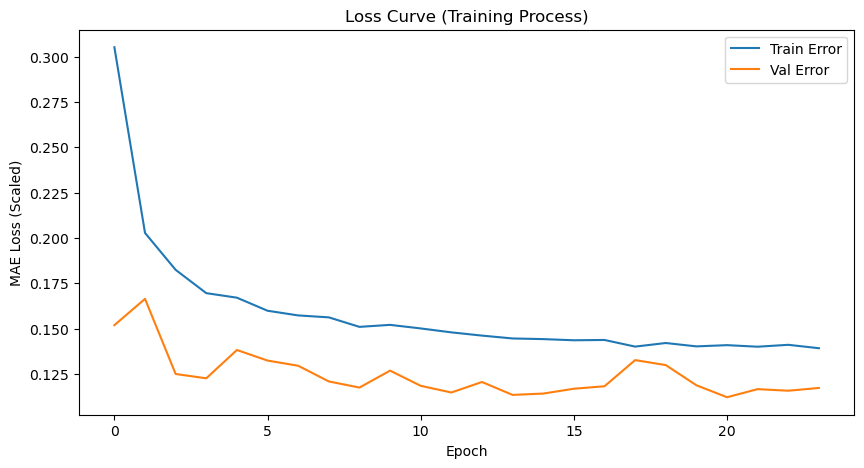


=== 6. Test Set Prediction & Evaluation ===
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step

[Final Evaluation Report]
Stopped at epoch 24
1. Mean Absolute Error (MAE): $127,847.33
2. Root Mean Squared Error (RMSE): $181,120.22
3. R² Score (Goodness of Fit): 0.9732
   (Closer to 1 indicates better model)

=== EX6. Show Prediction Comparison Table (Area ≈ 100 sqm) ===


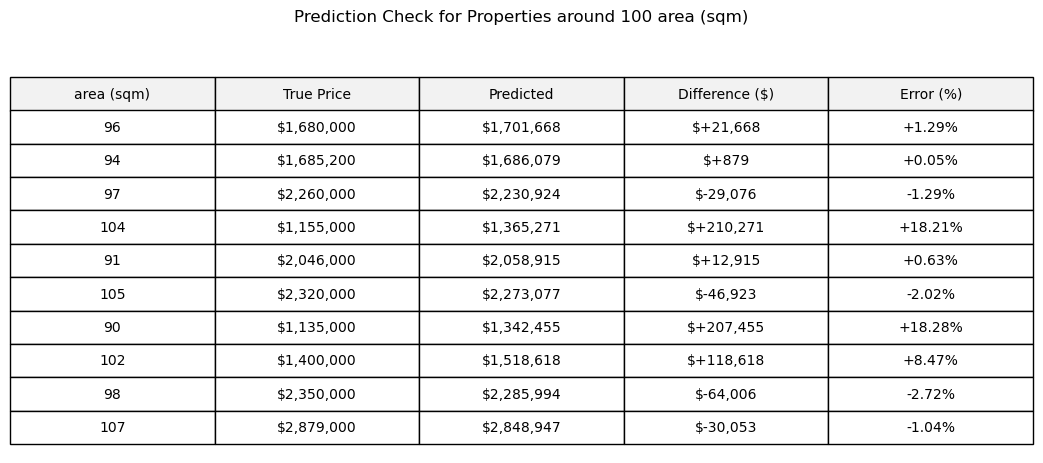


=== 7. Visualization (True vs Predicted) ===


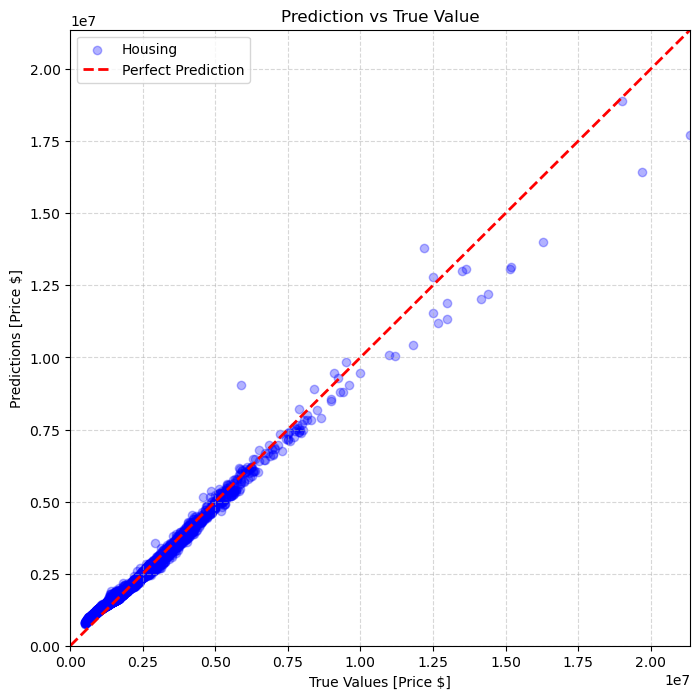


=== EX7. Supplemental Eval: Exclude Luxury (Price <= $7.5M) ===
Filter Threshold: <= $7,500,000
Sample Count: 10957 (Original Total: 11008)
------------------------------
1. Adjusted MAE : $124,637.47 (Original: $127,847.33)
2. Adjusted RMSE: $163,748.87 (Original: $181,120.22)
3. Mean Absolute Percentage Error (MAPE): 10.80%

[Info] Removed 51 luxury/high-priced units

Plotting filtered visualization...


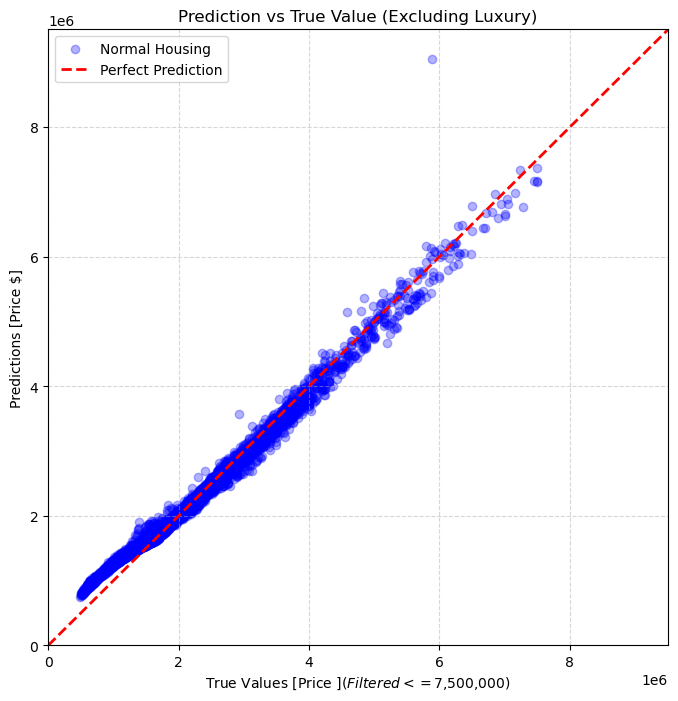


Program finished!


In [4]:
"""
Housing Price Prediction Model using TensorFlow/Keras
 
Key Features:
 - Preprocessing: Dual Standardization (scales both Features X and Target y)
 - Architecture: Dense Neural Network (DNN) with Dropout & Early Stopping
 - Evaluation: Inverse transformation for real-dollar metrics (MAE, RMSE, R²)
 - Visualization: Loss curves, 100sqm sample comparison, and non-luxury filtering

Please make sure that the necessary libraries and modules are installed in your environment(conda)
 - install cmd: conda install pandas numpy tensorflow scikit-learn matplotlib
 - check cmd: conda list | grep -E "pandas|numpy|tensorflow|scikit-learn|matplotlib"
"""


import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# ==========================================
# 1. Data Loading & Preprocessing
# ==========================================
print("=== 1. Load Data ===")

file_path = output_csv_path

if not os.path.exists(file_path):
    print(f"Error: File not found {file_path}")
    exit()

df = pd.read_csv(file_path)
print(f"-> Data loaded successfully, total {len(df)} rows")

# Clean null values again to prevent errors
df = df.dropna()

target_col = 'transacted price ($)'

# Drop irrelevant columns
drop_cols = [target_col, 'source_file', 'floor level', 'sale date', 'street name', 'project name']
drop_cols = [c for c in drop_cols if c in df.columns]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].copy()
# [Key] Reshape y to 2D array for StandardScaler
y = df[target_col].values.reshape(-1, 1)

# Feature Encoding
print("-> Encoding features...")
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# ==========================================
# [Key Step] Dual Standardization (Solve gradient explosion)
# ==========================================
print("-> Standardizing (features and target)...")

# 1. Standardize features X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 2. Standardize target y (convert millions into decimals between -3 and 3)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)


# ==========================================
# 2. Split Dataset
# ==========================================
print("\n=== 2. Split Dataset ===")

# Note: Here we train using y_scaled (scaled prices)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


# ==========================================
# 3. Define Model
# ==========================================
print("\n=== 3. Build Model ===")

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(1) # Output is the standardized value
])
print(model.summary())

# The default value of learning rate is 0.001
model.compile(
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error'])


# ==========================================
# 4. Train Model (with Early Stopping)
# ==========================================
print("\n=== 4. Start Training ===")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128, # Recommended 128 for 100k rows
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


# ==========================================
# 5. Visualize Training Process (Loss Curve)
# ==========================================
print("\n=== 5. Showing Loss Curve ===")

# Note: The Loss here is based on "scaled data", so values will be small (e.g., 0.1), which is normal.
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10, 5))
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss (Scaled)') # Indication that this is scaled error
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.legend()
    plt.title("Loss Curve (Training Process)")
    plt.show()

plot_history(history)


# ==========================================
# 6. Evaluation & Prediction (Restore Real Prices + Detailed Eval)
# ==========================================
print("\n=== 6. Test Set Prediction & Evaluation ===")

# 1. Model Prediction (Results are scaled values, e.g., 0.5)
preds_scaled = model.predict(X_test)

# 2. [Key] Restore to real dollar prices
# Without this step, predictions would be ~0.5 dollars instead of 2 million
predictions = scaler_y.inverse_transform(preds_scaled).flatten()
y_test_real = scaler_y.inverse_transform(y_test).flatten()

# 3. Calculate metrics (using restored real prices)
mae = mean_absolute_error(y_test_real, predictions)
mse = mean_squared_error(y_test_real, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, predictions)

print(f"\n[Final Evaluation Report]")
print(f"Stopped at epoch {len(history.history['loss'])}")
print(f"1. Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"2. Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"3. R² Score (Goodness of Fit): {r2:.4f}") 
print(f"   (Closer to 1 indicates better model)")


# ==========================================
# EX6. Prediction Sample Table (Area ≈ 100 sqm)
# ==========================================
print("\n=== EX6. Show Prediction Comparison Table (Area ≈ 100 sqm) ===")

# 1 Restore X_test to original values
X_test_restored = scaler_X.inverse_transform(X_test)
df_eval = pd.DataFrame(X_test_restored, columns=feature_cols)

# 2 Append True and Predicted prices to the table
df_eval['True Price'] = y_test_real
df_eval['Predicted'] = predictions

# [New] Calculate Difference and Error Percentage
df_eval['Diff'] = df_eval['Predicted'] - df_eval['True Price']
df_eval['Error_Pct'] = (df_eval['Diff'] / df_eval['True Price']) * 100

# 3 Logic: Find columns containing "area"
area_col_name = None
for col in feature_cols:
    if 'area' in col.lower() and 'sqm' in col.lower():
        area_col_name = col
        break
target_col = area_col_name if area_col_name else feature_cols[0]

# 4 Filter for area between 90 and 110
mask = (df_eval[target_col] >= 90) & (df_eval[target_col] <= 110)
sample_df = df_eval[mask].head(10).copy()

if len(sample_df) == 0:
    print("Alert: No data found for 90-110 sqm, showing random samples.")
    sample_df = df_eval.sample(10)

# 5 Format Data
# We want to show 5 columns
cols_to_show = [target_col, 'True Price', 'Predicted', 'Diff', 'Error_Pct']
table_data = []

for index, row in sample_df[cols_to_show].iterrows():
    area_fmt = f"{row[target_col]:.0f}"
    true_fmt = f"${row['True Price']:,.0f}"
    pred_fmt = f"${row['Predicted']:,.0f}"
    
    # [Modify] Difference with dollar sign and +/- sign
    diff_fmt = f"${row['Diff']:+,.0f}" 
    
    # [New] Error % format (e.g., +2.50%)
    error_fmt = f"{row['Error_Pct']:+.2f}%"
    
    table_data.append([area_fmt, true_fmt, pred_fmt, diff_fmt, error_fmt])

# 6 Draw Table using Matplotlib
fig, ax = plt.subplots(figsize=(11, 5)) # Slightly wider canvas for new columns
ax.axis('off')

# Define column headers
col_labels = [target_col, "True Price", "Predicted", "Difference ($)", "Error (%)"]

# Create table
the_table = ax.table(
    cellText=table_data,
    colLabels=col_labels,
    loc='center',
    cellLoc='center',
    colColours=['#f2f2f2']*5  # Background color for 5 headers
)

# Adjust table style
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 2.0) # Adjust row height

plt.title(f"Prediction Check for Properties around 100 {target_col}", y=1.1)
plt.show()


# ==========================================
# 7. Visualization (True vs Predicted)
# ==========================================
print("\n=== 7. Visualization (True vs Predicted) ===")

plt.figure(figsize=(8, 8))
# Use restored real prices (y_test_real) for plotting
plt.scatter(y_test_real, predictions, alpha=0.3, c='blue', label='Housing')
# plt.scatter(y_test_real, predictions, alpha=0.3) 
plt.xlabel('True Values [Price $]')
plt.ylabel('Predictions [Price $]')
plt.title('Prediction vs True Value')

# Draw diagonal line
lims = [0, max(y_test_real.max(), predictions.max())]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
# plt.plot(lims, lims, color='red') 
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5) # Add grid for easier reading
plt.show()


# ==========================================
# EX7. Visualization for Non-Luxury Home (True vs Predicted)
# ==========================================
print("\n=== EX7. Supplemental Eval: Exclude Luxury (Price <= $7.5M) ===")

# 1. Create a mask to filter true prices <= 7.5 million
# Note: Must use restored real prices y_test_real
threshold = 7_500_000
mask_normal = y_test_real <= threshold

# 2. Filter data
y_real_normal = y_test_real[mask_normal]
preds_normal = predictions[mask_normal]

# 3. Recalculate metrics
mae_normal = mean_absolute_error(y_real_normal, preds_normal)
rmse_normal = np.sqrt(mean_squared_error(y_real_normal, preds_normal))

# 4. Calculate Mean Absolute Percentage Error (MAPE) - More intuitive
# Formula: mean(|(True-Pred)/True|) * 100
mape_normal = np.mean(np.abs((y_real_normal - preds_normal) / y_real_normal)) * 100

print(f"Filter Threshold: <= ${threshold:,.0f}")
print(f"Sample Count: {len(y_real_normal)} (Original Total: {len(y_test_real)})")
print("-" * 30)
print(f"1. Adjusted MAE : ${mae_normal:,.2f} (Original: ${mae:,.2f})")
print(f"2. Adjusted RMSE: ${rmse_normal:,.2f} (Original: ${rmse:,.2f})")
print(f"3. Mean Absolute Percentage Error (MAPE): {mape_normal:.2f}%")

# 5. Visualize Comparison
if len(y_test_real) - len(y_real_normal) > 0:
    print(f"\n[Info] Removed {len(y_test_real) - len(y_real_normal)} luxury/high-priced units")
else:
    print("\n[Info] No units found over $7.5M, metrics unchanged.")

print("\nPlotting filtered visualization...")

plt.figure(figsize=(8, 8))

# Core modification: Use filtered "Normal Housing" data for plotting
plt.scatter(y_real_normal, preds_normal, alpha=0.3, c='blue', label='Normal Housing')

plt.xlabel(f'True Values [Price $] (Filtered <= ${threshold:,.0f})')
plt.ylabel('Predictions [Price $]')
plt.title('Prediction vs True Value (Excluding Luxury)')

# Dynamic axis range calculation
# Note: Must use max of y_real_normal, otherwise chart looks empty due to original luxury data
max_val = max(y_real_normal.max(), preds_normal.max())
lims = [0, max_val * 1.05] # Multiply by 1.05 for margin

# Draw diagonal line (Perfect Prediction)
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5) # Add grid
plt.show()

print("\nProgram finished!")